# Import Dependencies

In [59]:
%run ./../../utilities/model_frameworks/bifrost_neural_engine.ipynb

In [60]:
import pandas as pd
import numpy as np

# Binary Trend Classification
Classify the future trend of a given assert.

## Data

### Utils

In [61]:
def rsi(prices, n=14):
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed>=0].sum()/n
    down = -seed[seed<0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1.+rs)

    for i in range(n, len(prices)):
        delta = deltas[i-1] # cause the diff is 1 shorter

        if delta>0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(n-1) + upval)/n
        down = (down*(n-1) + downval)/n

        rs = up/down
        rsi[i] = 100. - 100./(1.+rs)

    return rsi

In [62]:
def add_indicators(data):
    # Indicators
    # Moving Average
    data['MA_7MA'] = data['close'].rolling(window=7).mean()
    data['MA_7MA_std'] = data['close'].rolling(window=7).std()
    data['MA_15MA'] = data['close'].rolling(window=15).mean()
    data['MA_30MA'] = data['close'].rolling(window=30).mean()
    data['MA_60MA'] = data['close'].rolling(window=60).mean()

    # MACD
    ewma = pd.Series.ewm
    close_26EMA = ewma(data['close'], span=26).mean()
    close_12EMA = ewma(data['close'], span=12).mean()
    data['MACD'] = close_12EMA - close_26EMA

    # Bollinger bands.
    no_of_std = 2
    data['MA_7MA_BB_high'] = data['MA_7MA'] + no_of_std * data['MA_7MA_std']
    data['MA_7MA_BB_low'] = data['MA_7MA'] - no_of_std * data['MA_7MA_std']

    # RSI
    data['rsi_6'] = rsi(data['close'].values, 6)
    data['rsi_14'] = rsi(data['close'].values, 14)
    data['rsi_20'] = rsi(data['close'].values, 20)
    
    return data

In [63]:
def get_change(current, previous):
    result = 0
    
    if current == previous:
        return result

    try:
        result = (abs(current - previous) / previous) * 100.0
    except ZeroDivisionError:
        result = 0

    return result if current > previous else -result

### Load Data

In [64]:
data = pd.read_json('./../../data/DOGE_BTC-1h.json')
data.columns = [ 'time', 'open', 'high', 'low', 'close', 'volume' ]
data['time'] = pd.to_datetime(data['time'], unit='ms')

### Add External Regressors

In [65]:
data = add_indicators(data)
data = data.dropna()

### Labeling

In [66]:
data['close_pred'] = data['close'].shift(-6)
data['delta_6'] = data.apply(lambda row: get_change(row['close'], row['close_pred']), axis=1)
data['future_up_trend'] = np.where(data['delta_6'] > 0, 1, 0)
data = data.drop('close_pred', axis=1)
data = data.drop('delta_6', axis=1)

In [67]:
data.head()

,time,open,high,low,close,volume,MA_7MA,MA_7MA_std,MA_15MA,MA_30MA,MA_60MA,MACD,MA_7MA_BB_high,MA_7MA_BB_low,rsi_6,rsi_14,rsi_20,future_up_trend
59,2022-04-06 11:00:00,0.000003,0.000003,0.000003,0.000003,13399441,0.000004,6.872998e-08,0.000004,0.000004,0.000003,1.424438e-08,0.000004,0.000003,26.090236,43.127170,48.148352,1
60,2022-04-06 12:00:00,0.000003,0.000003,0.000003,0.000003,8492852,0.000003,7.470577e-08,0.000004,0.000004,0.000003,4.293385e-09,0.000004,0.000003,24.890280,42.427941,47.601166,1
61,2022-04-06 13:00:00,0.000003,0.000003,0.000003,0.000003,27427574,0.000003,7.696629e-08,0.000004,0.000004,0.000003,-8.299765e-09,0.000004,0.000003,18.698379,38.404594,44.413335,0
62,2022-04-06 14:00:00,0.000003,0.000003,0.000003,0.000003,15959655,0.000003,7.057586e-08,0.000004,0.000004,0.000003,-1.648667e-08,0.000004,0.000003,26.056304,40.432322,45.689528,1
63,2022-04-06 15:00:00,0.000003,0.000003,0.000003,0.000003,11639818,0.000003,4.270608e-08,0.000003,0.000004,0.000003,-2.112755e-08,0.000003,0.000003,33.300045,42.471835,46.971076,1


## Model

### Train the Model

Epoch: 999951, Loss: 0.11470916122198105 (Prev: 0.1196395754814148): 100%|██████████| 1000000/1000000 [2:34:04<00:00, 108.17it/s]  


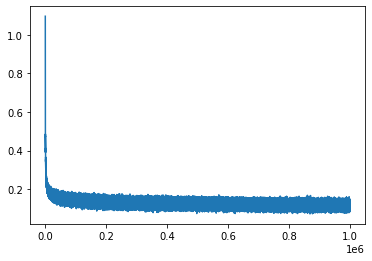

In [68]:
model = BifrostNeuralEngine(data=data,
                            autobootstrap_filename='../../data/doge_btc_delta_6_trend_binance_model.pt',
                            labels_column_names=['future_up_trend'],
                            date_column_name='time',
                            layers_config=[100, 250, 75,75,150]) \
    .fit(epochs=100*1000*10)

### Make Predictions

In [69]:
prediction_frame = data.copy()
predictions = model.predict(prediction_frame)
prediction_frame.index = prediction_frame.time
predicted_df = pd.DataFrame(predictions)
predicted_df.columns = ['future_up_trend']
predicted_df.index = prediction_frame.index
prediction_frame['future_up_trend_pred'] = np.where(predicted_df['future_up_trend'] > 0, 1, 0)

prediction_frame['close_pred'] = prediction_frame['close'].shift(-6)
prediction_frame['delta_6'] = prediction_frame.apply(lambda row: get_change(row['close'], row['close_pred']), axis=1)
prediction_frame['future_up_trend'] = np.where(prediction_frame['delta_6'] > 0, 1, 0)
prediction_frame = prediction_frame.drop('close_pred', axis=1)
prediction_frame = prediction_frame.drop('delta_6', axis=1)

#  Accuracy
accuracy_filter = pd.DataFrame(prediction_frame['future_up_trend'] == prediction_frame['future_up_trend_pred'])

In [70]:
correct_count = accuracy_filter[accuracy_filter[0] == True].shape[0]
incorrect_count = accuracy_filter[accuracy_filter[0] == False].shape[0]
accuracy = min(correct_count, incorrect_count) / max(correct_count, incorrect_count) * 100

print(f'{round(accuracy)}% (Prev: 69%) Accuracy (Total: {accuracy_filter.shape[0]}, Correct: {correct_count}, Incorrect: {incorrect_count})')

99% (Prev: 69%) Accuracy (Total: 1388, Correct: 699, Incorrect: 689)
